In [1]:
from gensim import corpora, models, similarities
import gensim

In [2]:
import json 
import gzip 
#from StringIO import StringIO
import urllib.request
import requests, zipfile, io
import re

def parse(url): 
    if re.match("^http", url):
        r = requests.get(url)
        g = gzip.open(io.BytesIO(r.content))
    else:
        g = gzip.open(url, 'r') 
    for l in g:
        yield eval(l)

import json 
import gzip 
def parse(url): 
    g = gzip.open(url, 'r') 
    for l in g: 
        yield eval(l)

In [3]:
import gensim
import nltk
stoplist = nltk.corpus.stopwords.words('english')
lemma = nltk.stem.wordnet.WordNetLemmatizer()

def myReviews(review_files_urls, catFilter = None, asin = None, concatenate = False, max_count = None):
    preprocess_reviewText = []
    for url in review_files_urls:
        print("Processing url: " + url)
        review_item_iterator = iter(parse(url))
        it = 0
        conc_count = 0
        for review_item in review_item_iterator:
            it += 1
            if (max_count is not None) and (it > max_count):
                return
        #for it in range(1000000):
            if it%100000==0:
                print("it="+str(it))

            reviewText = review_item["reviewText"]
            label = review_item["asin"] + "_" + review_item["reviewerID"] 
            preprocess_reviewText_i = gensim.utils.simple_preprocess(reviewText)
            preprocess_reviewText_i = [lemma.lemmatize(word) for word in preprocess_reviewText_i if word not in stoplist]


            #yield gensim.models.doc2vec.LabeledSentence(words=preprocess_reviewText, tags=[label])
            if (catFilter == None or (catFilter in review_item["categories"])) and (asin == None or (asin == review_item["asin"])):
                if concatenate==False:
                    yield preprocess_reviewText_i
                else:
                    conc_count += 1
                    preprocess_reviewText.extend(preprocess_reviewText_i)
                    print("Concatenated count: "+str(conc_count))
    if concatenate == True:
        print("Return the final text with length: "+str(len(preprocess_reviewText)))
        print(preprocess_reviewText)
        yield preprocess_reviewText

#base_url = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/"
base_url = "/media/mister/ntfs/Rainer/y2buy/download/amazon_reviews_96_14/"

from bs4 import BeautifulSoup
import urllib.request


html = urllib.request.urlopen("http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/")
soup = BeautifulSoup(html, 'html.parser')
#print(soup.prettify())
all_html_links = soup.find_all('a')
review_file_names = [links["href"] for links in all_html_links if re.match("^review.*[^_5|_10].json.gz$", links["href"])]

In [4]:
from os import listdir
from os.path import isfile, join
import re
#base_url = "/media/mister/ntfs/Rainer/y2buy/download/amazon_reviews_96_14/"
base_url = "/media/mister/Extension/dev/download/word2vec"
onlyfiles = [f for f in listdir(base_url) if isfile(join(base_url, f))]
#review_file_names = [file for file in onlyfiles if re.match("^review.*[^_5|_10].json.gz$", file)]
review_file_names = ["reviews_Electronics.json.gz","reviews_Cell_Phones_and_Accessories.json.gz"]

for links in all_html_links:
    if re.match("^review.*[^_5|_10].json.gz$", links["href"]):
        print(links["href"])

In [5]:


review_file_names= ["reviews_Books_10.json.gz" if file_name =="reviews_Books.json.gz" else file_name for file_name in review_file_names]
print(review_file_names)
review_file_urls = [base_url + review_file_name for review_file_name in review_file_names]
#print(review_file_urls)

['reviews_Electronics.json.gz', 'reviews_Cell_Phones_and_Accessories.json.gz']


In [6]:
  
import os
#dictionaryFileName = '../../download/word2vec/reviews_all.dict'
dictionaryFileName = '../../download/word2vec/reviews_electronic_cell_phones.dict'
if os.path.isfile(dictionaryFileName)==False:
    #dictionary = corpora.Dictionary(myReviews("Cell Phones"))
    dictionary = corpora.Dictionary()
    for review_file_url in review_file_urls:
        dictionary.add_documents(myReviews([review_file_url],max_count = 1000000))
        from six import iteritems
        once_ids = [tokenid for tokenid, docfreq in iteritems(dictionary.dfs) if docfreq == 1]
        dictionary.filter_tokens(once_ids)  # remove stop words and words that appear only once
        dictionary.compactify()  # remove gaps in id sequence after words that were removed
        print(dictionary)
    dictionary.save(dictionaryFileName)  # store the dictionary, for future reference
else:
    dictionary = corpora.Dictionary.load(dictionaryFileName)




    
import os
dictionaryFileName = '../../download/word2vec/reviews_all.dict'
if os.path.isfile(dictionaryFileName)==False:
    #dictionary = corpora.Dictionary(myReviews("Cell Phones"))
    dictionary = corpora.Dictionary(myReviews(review_file_urls))
    from six import iteritems
    once_ids = [tokenid for tokenid, docfreq in iteritems(dictionary.dfs) if docfreq == 1]
    dictionary.filter_tokens(once_ids)  # remove stop words and words that appear only once
    dictionary.compactify()  # remove gaps in id sequence after words that were removed
    dictionary.save(dictionaryFileName)  # store the dictionary, for future reference
else:
    dictionary = corpora.Dictionary.load(dictionaryFileName)

print(dictionary)

In [7]:
def myCorpus(review_file_urls, catFilter = None, asin = None, concatenate = False, max_count = None):
    for review in myReviews(review_file_urls,catFilter,asin,concatenate,max_count):
    # assume there's one document per line, tokens separated by whitespace
        yield dictionary.doc2bow(review)

In [8]:
import os
tfidfFileName ='../../download/word2vec/reviews_electronic_cell_phones.tfidf'

if os.path.isfile(tfidfFileName)==False:
    #tfidf = models.TfidfModel(myCorpus(review_file_urls,max_count = 1000000))
    tfidf = models.TfidfModel(myCorpus(review_file_urls))
    tfidf.save(tfidfFileName)
else:
    tfidf = models.TfidfModel.load(tfidfFileName)
print(tfidf)

TfidfModel(num_docs=11271731, num_nnz=349471799)


In [9]:
import pickle

#tfidf_document_FileName ='../../download/word2vec/reviews_cell_phones_review.tfidf'
tfidf_document_FileName ='../../download/word2vec/reviews_cell_phone_of_electronic_cell_phones_dict.corpus'
if os.path.isfile(tfidf_document_FileName)==False:
    document = next(myCorpus(review_file_urls = ['../../download/word2vec/reviews_Cell_Phones_and_Accessories_w_Cat.json.gz'], catFilter="Cell Phones",concatenate=True))
    document_tfidf = tfidf[document]  
    pickle.dump(document, open(tfidf_document_FileName, 'wb'))
else:
    document = pickle.load( open( tfidf_document_FileName, "rb" ) )
    document_tfidf = tfidf[document]  
    
document_dict = dict((tokenid, count) for tokenid, count in document)
    
    


In [10]:
import gensim
model = gensim.models.Word2Vec.load('../../download/word2vec/myamazonmodel.word2vec')
#model = gensim.models.KeyedVectors.load_word2vec_format('../../download/word2vec/GoogleNews-vectors-negative300.bin', binary=True, limit=400000) 

In [84]:
import numpy as np
import pandas as pd
tbl =[[dictionary.get(tokenid), document_dict[tokenid], tfidf_value ,model.wv[dictionary.get(tokenid)] ] for (tokenid,tfidf_value) in document_tfidf if tfidf_value > 0.05 and dictionary.get(tokenid) in model.wv]

df = pd.DataFrame(data=tbl,
                  columns=["token","term_freq","tfidf", "word_vector"]
                  )
df = df.sort_values('tfidf', ascending=False)
df.set_index("token")
print(df)

       token  term_freq     tfidf  \
13     phone     424902  0.656997   
39      call      36115  0.122114   
25    screen      51072  0.105990   
19   battery      48257  0.102919   
44       sim      17723  0.094905   
41      apps      22849  0.093862   
38    mobile      20957  0.093014   
40   android      21694  0.089413   
34      good      63078  0.086899   
18       use      59604  0.084637   
43     nokia      15863  0.083463   
33      text      17968  0.082431   
11       one      66062  0.081378   
9        get      52578  0.081020   
42  unlocked      13680  0.079244   
16      like      55524  0.078898   
28      card      27391  0.077057   
6     camera      32454  0.076974   
8       time      45455  0.073625   
32   service      23268  0.073229   
10       new      32494  0.071657   
12      work      58879  0.071420   
7    feature      25236  0.070699   
24       day      30518  0.068974   
0      great      58669  0.068293   
22   problem      32263  0.065813   
1

In [85]:
import nltk
from nltk.cluster.kmeans import KMeansClusterer
nc = 5
data = df.loc[:,"word_vector"]
#print(data)
kclusterer = KMeansClusterer(nc, distance=nltk.cluster.util.cosine_distance, avoid_empty_clusters=True) #repeats=30,
assigned_clusters = kclusterer.cluster(data, assign_clusters=True)
#print(assigned_clusters)
means = np.asarray( kclusterer.means())


In [86]:
df["cluster_kmeans"] = pd.Series(assigned_clusters, index=df.index)

In [87]:
data = np.array([row for row in data])
print(data)


[[-1.04809 -1.02451 -0.9555  ...,  0.02164  0.16549  0.51798]
 [-0.33118 -3.82637  3.85393 ..., -1.22355  2.777    0.77693]
 [-1.17817 -2.13697  0.90986 ...,  3.1373  -2.25148 -1.03483]
 ..., 
 [ 0.48118 -0.81493 -0.46859 ..., -1.52405  1.52433  0.21068]
 [-0.70488 -2.96473 -2.09724 ...,  0.13413  1.25594  0.41133]
 [ 0.14541  1.78674  4.48221 ..., -1.27275  1.58146  3.62919]]


In [88]:
#print(data.shape)
#print(data[0].shape)
#print(type(data[0]))
#print(data[0])

In [89]:
from sklearn.cluster import DBSCAN
from sklearn import metrics


#db = DBSCAN(eps=0.03, min_samples=10).fit(data)
db = DBSCAN(min_samples=2, metric='cosine', algorithm='brute').fit(data) #metric="cosine"
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
print(len(labels))
print(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters_)

#print('Estimated number of clusters: %d' % n_clusters_)
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#print("Adjusted Rand Index: %0.3f"
#      % metrics.adjusted_rand_score(labels_true, labels))
#print("Adjusted Mutual Information: %0.3f"
#      % metrics.adjusted_mutual_info_score(labels_true, labels))
#print("Silhouette Coefficient: %0.3f"
#      % metrics.silhouette_score(X, labels))

45
[ 0 -1 -1 -1 -1  1  1  1  2 -1  1 -1 -1 -1 -1 -1 -1 -1  3 -1 -1 -1 -1  3  2
 -1 -1  1 -1  1 -1 -1  0 -1 -1  4  4  3  3 -1 -1 -1 -1 -1 -1]
5


In [90]:
df["cluster_dbscan"] = pd.Series(labels, index=df.index)

print(df.shape)
print(df)

(45, 6)
       token  term_freq     tfidf  \
13     phone     424902  0.656997   
39      call      36115  0.122114   
25    screen      51072  0.105990   
19   battery      48257  0.102919   
44       sim      17723  0.094905   
41      apps      22849  0.093862   
38    mobile      20957  0.093014   
40   android      21694  0.089413   
34      good      63078  0.086899   
18       use      59604  0.084637   
43     nokia      15863  0.083463   
33      text      17968  0.082431   
11       one      66062  0.081378   
9        get      52578  0.081020   
42  unlocked      13680  0.079244   
16      like      55524  0.078898   
28      card      27391  0.077057   
6     camera      32454  0.076974   
8       time      45455  0.073625   
32   service      23268  0.073229   
10       new      32494  0.071657   
12      work      58879  0.071420   
7    feature      25236  0.070699   
24       day      30518  0.068974   
0      great      58669  0.068293   
22   problem      32263  0.065

In [91]:
df["centroid"] = pd.Series( means[assigned_clusters].tolist(), index=df.index)

print(df.shape)
print(df)


(45, 7)
       token  term_freq     tfidf  \
13     phone     424902  0.656997   
39      call      36115  0.122114   
25    screen      51072  0.105990   
19   battery      48257  0.102919   
44       sim      17723  0.094905   
41      apps      22849  0.093862   
38    mobile      20957  0.093014   
40   android      21694  0.089413   
34      good      63078  0.086899   
18       use      59604  0.084637   
43     nokia      15863  0.083463   
33      text      17968  0.082431   
11       one      66062  0.081378   
9        get      52578  0.081020   
42  unlocked      13680  0.079244   
16      like      55524  0.078898   
28      card      27391  0.077057   
6     camera      32454  0.076974   
8       time      45455  0.073625   
32   service      23268  0.073229   
10       new      32494  0.071657   
12      work      58879  0.071420   
7    feature      25236  0.070699   
24       day      30518  0.068974   
0      great      58669  0.068293   
22   problem      32263  0.065

In [92]:
df["centroid_distance"] = df.apply(lambda row:nltk.cluster.util.cosine_distance(row['word_vector'], row['centroid']), axis=1)

print(df.shape)
print(df)

(45, 8)
       token  term_freq     tfidf  \
13     phone     424902  0.656997   
39      call      36115  0.122114   
25    screen      51072  0.105990   
19   battery      48257  0.102919   
44       sim      17723  0.094905   
41      apps      22849  0.093862   
38    mobile      20957  0.093014   
40   android      21694  0.089413   
34      good      63078  0.086899   
18       use      59604  0.084637   
43     nokia      15863  0.083463   
33      text      17968  0.082431   
11       one      66062  0.081378   
9        get      52578  0.081020   
42  unlocked      13680  0.079244   
16      like      55524  0.078898   
28      card      27391  0.077057   
6     camera      32454  0.076974   
8       time      45455  0.073625   
32   service      23268  0.073229   
10       new      32494  0.071657   
12      work      58879  0.071420   
7    feature      25236  0.070699   
24       day      30518  0.068974   
0      great      58669  0.068293   
22   problem      32263  0.065

In [93]:
# now hierarchical clustering
# https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
# needed imports
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

In [94]:
# some setting for this notebook to actually show the graphs inline, you probably won't need this
%matplotlib inline
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

In [95]:
# generate the linkage matrix
Z = linkage(data, metric='cosine')
#Z = linkage(data, 'ward')

In [96]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(data))
c

0.49611628681333553

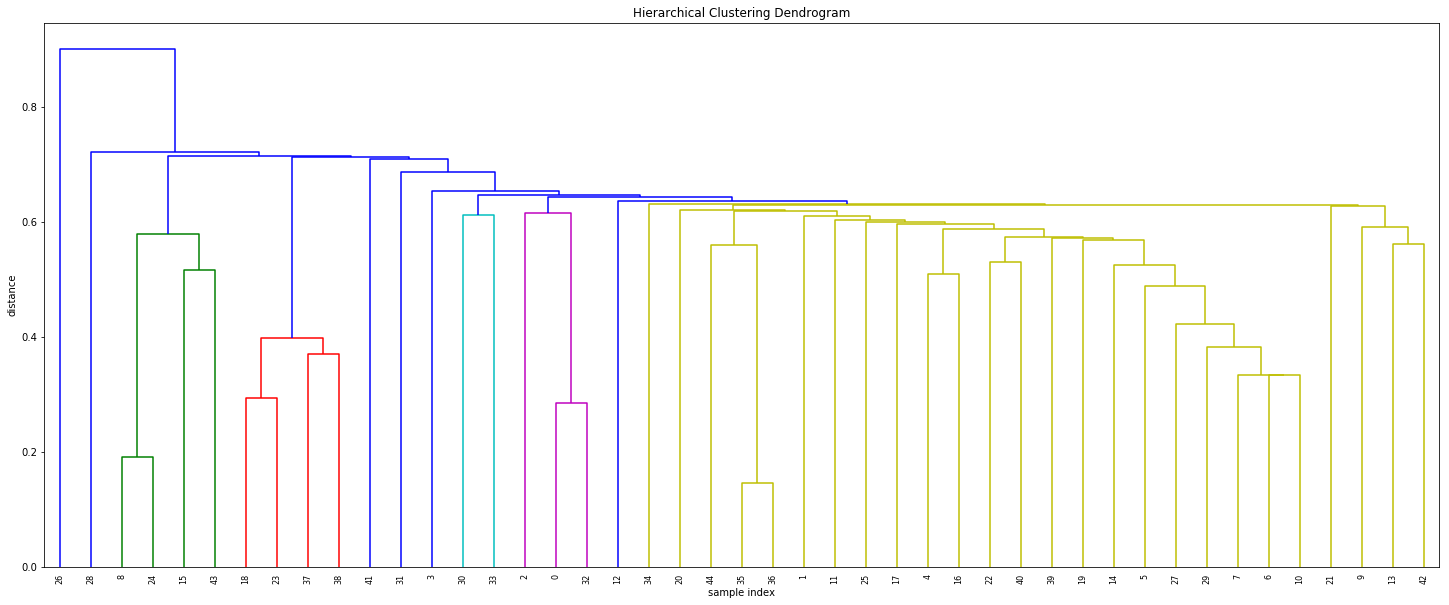

In [97]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

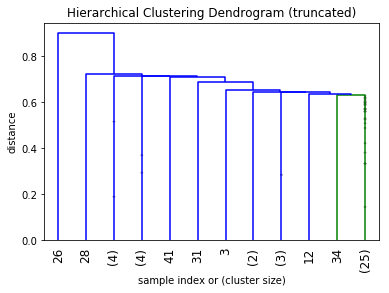

In [98]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [99]:
from scipy.cluster.hierarchy import fcluster
#k=12
#cluster_hierachical = fcluster(Z, k, criterion='maxclust')


max_d = 0.5
cluster_hierachical = fcluster(Z, max_d, criterion='distance')
cluster_hierachical

#cluster_hierachical = fcluster(Z, 8, depth=30)
#cluster_hierachical


array([ 7, 22,  8, 30, 11, 15, 15, 15,  1, 26, 15, 21, 29, 24, 16,  2, 12,
       19,  4, 17, 23, 27, 13,  4,  1, 20, 34, 15, 33, 15,  5, 31,  7,  6,
       28,  9,  9,  4,  4, 18, 14, 32, 25,  3, 10], dtype=int32)

In [100]:
df["cluster_hierarchical"] = pd.Series(cluster_hierachical, index=df.index)
#print(df.shape)
#print(df)

In [101]:
writer = pd.ExcelWriter('clustered_smartphone_features.xlsx')
df.to_excel(writer,'Sheet1')
writer.save()